# Practical Exercise 2. Classification and Logistic regression

## Part One. Binary Problem

       Call  Failure    Complains  Subscription  Length  Charge  Amount  \
count    3150.000000  3150.000000           3150.000000     3150.000000   
mean        7.627937     0.076508             32.541905        0.942857   
std         7.263886     0.265851              8.573482        1.521072   
min         0.000000     0.000000              3.000000        0.000000   
25%         1.000000     0.000000             30.000000        0.000000   
50%         6.000000     0.000000             35.000000        0.000000   
75%        12.000000     0.000000             38.000000        1.000000   
max        36.000000     1.000000             47.000000       10.000000   

       Seconds of Use  Frequency of use  Frequency of SMS  \
count     3150.000000       3150.000000       3150.000000   
mean      4472.459683         69.460635         73.174921   
std       4197.908687         57.413308        112.237560   
min          0.000000          0.000000          0.000000   
25%       1391.2500

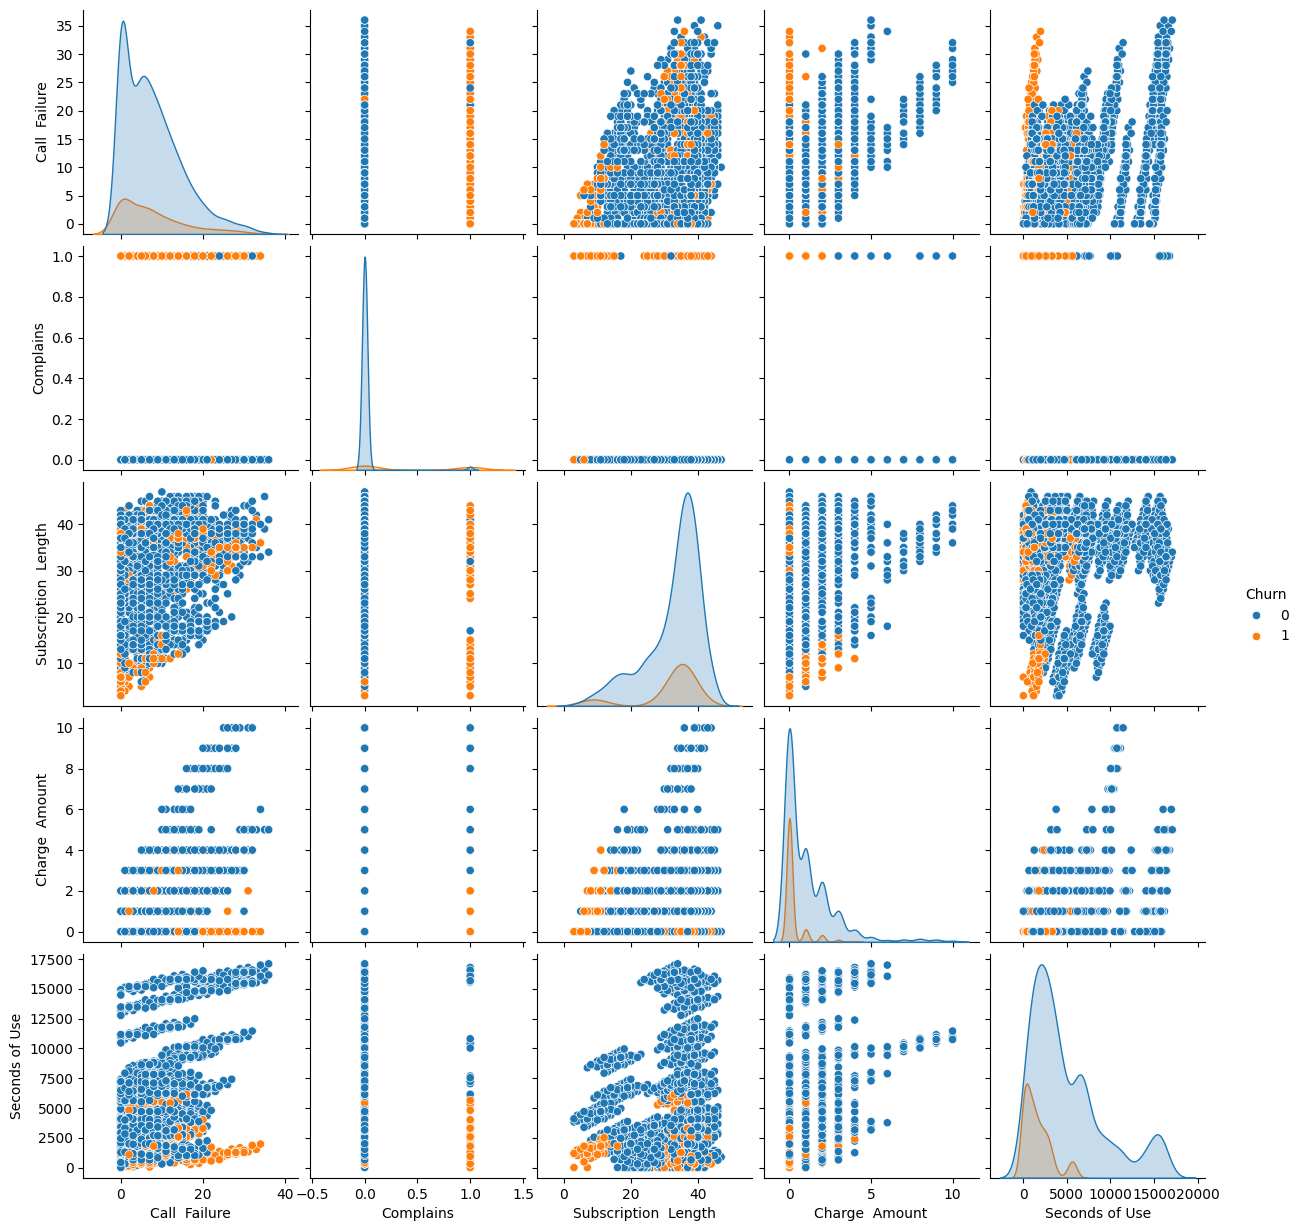

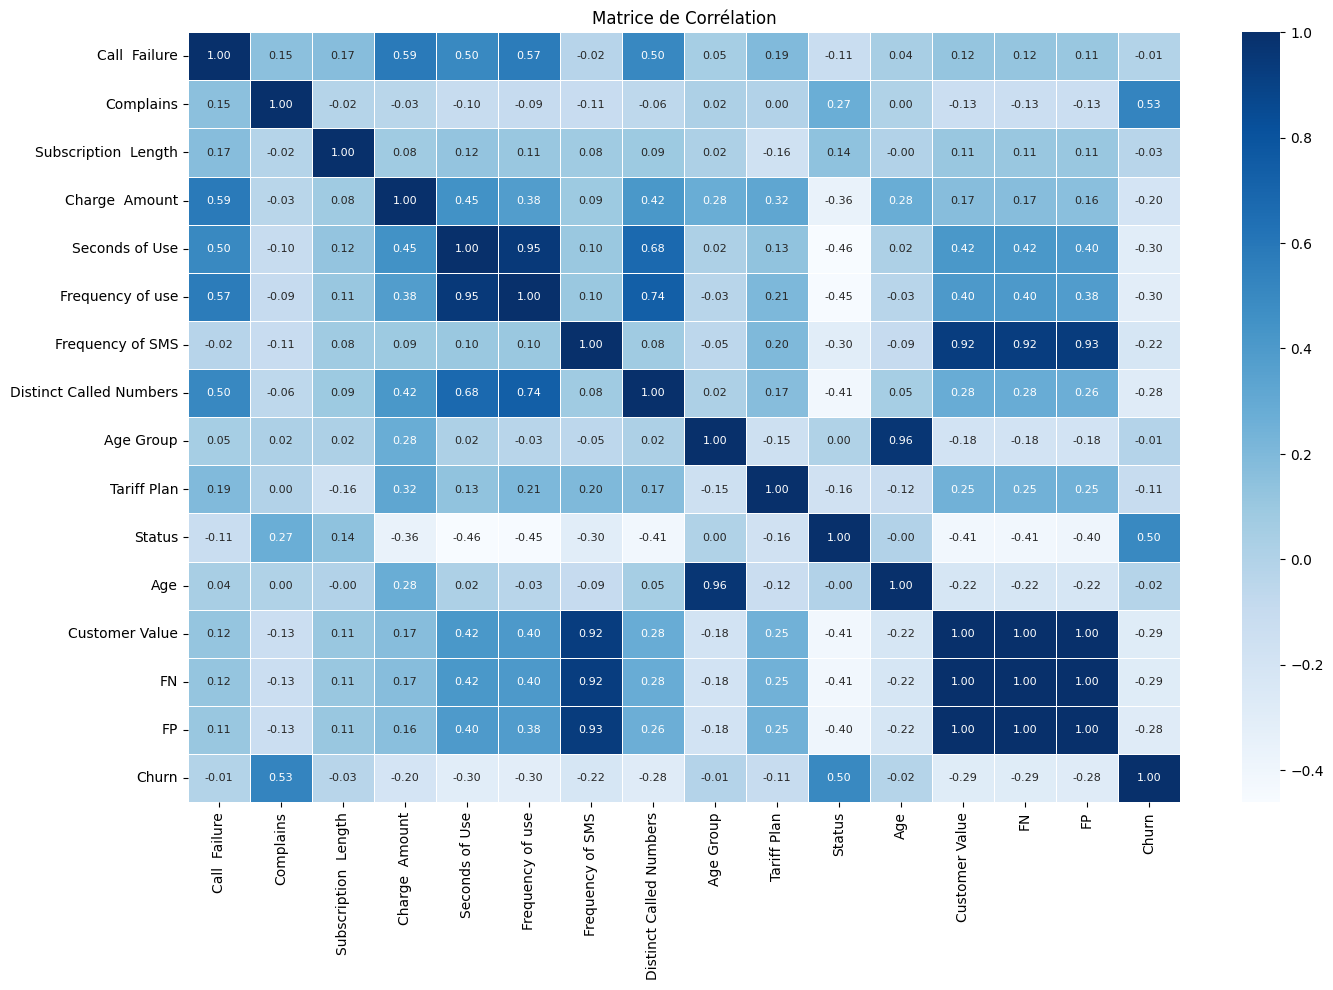

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

data = pd.read_csv("/content/sample_data/customer_data.csv")

print(data.describe())

ColNames = data.columns.tolist()

sns.pairplot(data, hue=ColNames[-1], vars=ColNames[0:5])
plt.show()

plt.figure(figsize=(16, 10))
sns.heatmap(data.corr(),
            cmap="Blues",
            annot=True,
            fmt=".2f",
            annot_kws={"size": 8},
            linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

## Part Two. Multi-Class Problem

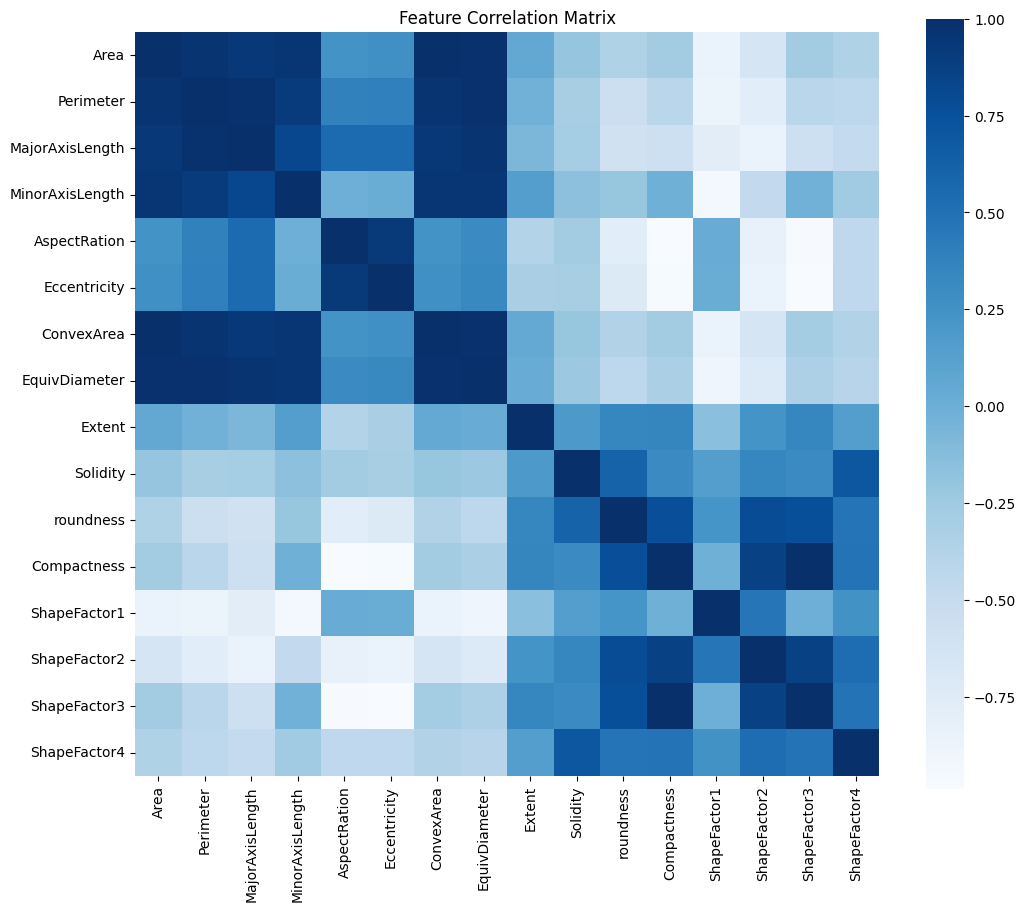


--- Regularization Lambda: 0 ---
Training Accuracy: 91.89%
Testing Accuracy: 92.21%


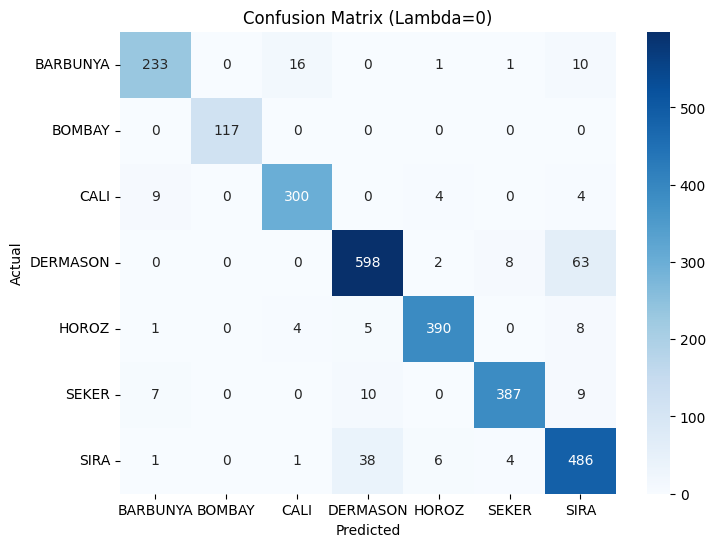


--- Regularization Lambda: 1 ---
Training Accuracy: 91.59%
Testing Accuracy: 92.29%


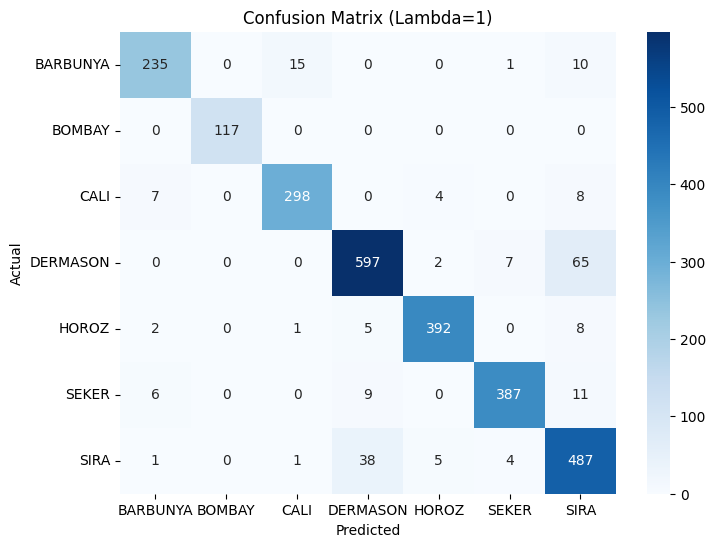


--- Regularization Lambda: 5 ---
Training Accuracy: 91.50%
Testing Accuracy: 91.99%


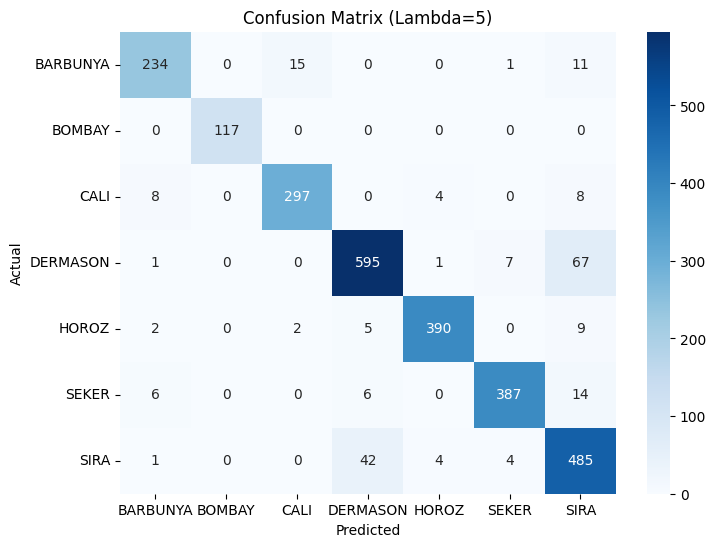


--- Regularization Lambda: 10 ---
Training Accuracy: 91.22%
Testing Accuracy: 91.81%


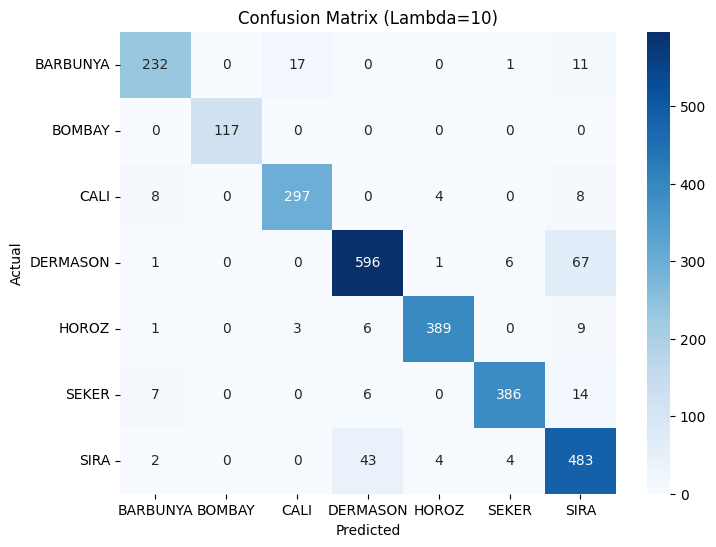

In [1]:
# Load dataset and display correlation heatmap.
# Perform One-Hot Encoding for the 'Class' column.
# Split data into Training and Testing sets.
# Scale features and add Bias term.
# Implement Cost Function with Regularization.
# Use scipy.optimize.minimize to train One-vs-All classifiers.
# Test different Lambda values and display accuracy/confusion matrix.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

data = pd.read_csv("/content/sample_data/drybeans_data.csv")

plt.figure(figsize=(12, 10))
sns.heatmap(data.drop(columns=['Class']).corr(), cmap="Blues", annot=False, square=True)
plt.title("Feature Correlation Matrix")
plt.show()

Y_onehot = pd.get_dummies(data["Class"]).to_numpy()
X = data.drop(columns=["Class"]).to_numpy()
labels = sorted(data["Class"].unique())

X_tr, X_tst, Y_tr, Y_tst = train_test_split(X, Y_onehot, test_size=0.2, random_state=42)

mu = X_tr.mean(axis=0)
sigma = X_tr.std(axis=0)

X_tr_norm = (X_tr - mu) / sigma
X_tst_norm = (X_tst - mu) / sigma

m_tr = X_tr.shape[0]
m_tst = X_tst.shape[0]

X_train = np.c_[np.ones(m_tr), X_tr_norm]
X_test = np.c_[np.ones(m_tst), X_tst_norm]
Y_train = Y_tr
Y_test = Y_tst

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def costFunctionReg(theta, X, Y, reg_lambda):
    m = len(Y)
    h = sigmoid(X.dot(theta))
    epsilon = 1e-5

    term1 = Y * np.log(h + epsilon)
    term2 = (1 - Y) * np.log(1 - h + epsilon)
    cost = (-1 / m) * np.sum(term1 + term2)

    theta_reg = theta.copy()
    theta_reg[0] = 0
    reg = (reg_lambda / (2 * m)) * np.sum(theta_reg**2)

    return cost + reg

def trainOneVsAll(X, Y, num_labels, reg_lambda):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n))

    for i in range(num_labels):
        initial_theta = np.zeros(n)
        target_class = Y[:, i]
        result = minimize(costFunctionReg, initial_theta, args=(X, target_class, reg_lambda), method='CG', options={'maxiter': 50})
        all_theta[i, :] = result.x
    return all_theta

def predict(all_theta, X):
    h = sigmoid(X.dot(all_theta.T))
    return np.argmax(h, axis=1)

lambda_values = [0, 1, 5, 10]

for lmbd in lambda_values:
    print(f"\n--- Regularization Lambda: {lmbd} ---")

    all_theta = trainOneVsAll(X_train, Y_train, len(labels), lmbd)

    pred_train = predict(all_theta, X_train)
    true_train = np.argmax(Y_train, axis=1)
    acc_train = np.mean(pred_train == true_train)

    pred_test = predict(all_theta, X_test)
    true_test = np.argmax(Y_test, axis=1)
    acc_test = np.mean(pred_test == true_test)

    print(f"Training Accuracy: {acc_train*100:.2f}%")
    print(f"Testing Accuracy: {acc_test*100:.2f}%")

    cm = confusion_matrix(true_test, pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (Lambda={lmbd})')
    plt.show()

I tested different values for the regularization parameter $\lambda$. The model tries to fit the training data exactly and increasing $\lambda$ adds a penalty for large parameter weights. So accuracy remained stable or changed slightly. If the training accuracy decreases slightly while testing accuracy remains high, it indicates that regularization is successfully reducing overfitting.

The confusion matrices show that most predictions lie on the diagonal. Errors mostly occur between bean types that are physically very similar.